# MRN Normalization

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  MRN Normalization
4.  Quick shot at maching learning.

"Trimmed Mean of M-values" (TMM) normalization, published by [Robinson and Oshlack](https://www.frontiersin.org/articles/10.3389/fgene.2016.00164/full#B16) is a widely used method of normalizing gene expression in scRNA data.  A variant called MRN (Median Ratio Normalization) is described by [Maza et al.](https://www.tandfonline.com/doi/full/10.4161/cib.25849), and may perform slightly better than TMM.  We carry out MRN normalization on the P1902 scRNA data, and use the results in a quick machine learning application.

#### Notebook created by Marty, step v-vii by Diana

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

Go to section 2, if you have already loaded the data and have the pickles.

# 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.

In this section, we load the gene expression data and some metadata.  The sequencing data is stored in a series of quant.sf files, one for each cell.  The metadata is stored in a separate file.  We use the metadata to select single-cells from an experiment.  The first function loads the metadata.

In [ ]:
def get_meta(experiment, filename = 'META_DATA_InVitro.csv', report=True, bulks = False):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    if bulks:
        df = df[ df['Number_Of_Cells'] > 1] # Include only bulks.
    else:
        df = df[ df['Number_Of_Cells'] == 1] # Get rid of bulks.
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [ ]:
meta_df = get_meta('P1902', filename = 'META_DATA_MARTY_InVitro_FEB8.csv')

In [ ]:
meta_bulks = get_meta('P1902', filename = 'META_DATA_MARTY_InVitro_FEB8.csv', bulks=True)

The sequencing data (in a quant.sf file) contains a separate row for each *isoform* of each gene.  The name of each row contains various information (separated by pipe-characters), from which we extract the gene name.

In [ ]:
def get_genename(longname):
    split_name = longname.split('|') # Separate by pipe
    if len(split_name) >= 5: # Avoid spike-ins.
        return split_name[5] # Gene name happens to be in 5th slot.
    else:
        return 'notagene'

The following function locates a quant.sf file from a cell name.  This is dependent on the directory structure.  Once located, the data is loaded into a data frame and output.

In [ ]:
def load_cell(sample_id):
    path = sample_id[:5]
    folderlist = os.listdir(path)
    folders = [f for f in folderlist if sample_id in f]
    if len(folders) == 0:
        raise FileNotFoundError('Cell data not found')
        return None
    elif len(folders) > 1:
        print('Multiple files found, and I cannot choose.')
        return None
    else:
        cwd = os.getcwd()
        path_to_cell = os.path.join(path,folders[0],'quant.sf')
        df = pd.read_csv(path_to_cell, sep='\t',
                         index_col=0, header=0, low_memory=False)
        df.index = [get_genename(longname) for longname in df.index]
        df = df.loc[ df.index != 'notagene']
        df.name = sample_id
        return df

The data for each cell is complicated -- more than we need to work with.  We care about the counts for each gene, putting all isoforms together at the moment.  The following function takes a dataframe for a cell, and outputs a series of gene expressions, indexed by genes.  We use the raw number of reads here, for use in TMM normalization later.

In [ ]:
def get_reads(cell, verbose = False):
    cg = cell.groupby(cell.index)['NumReads'].sum()
    cg.name = cell.name
    if verbose:
        print('Gene expression (NumReads) found for {} genes.'.format(len(cg)))
        print('{0:2.0%} of expressions are zero.'.format(cg.astype(bool).sum() / len(cg)))
    return cg

The next function loads an entire *list* of cells, and places their gene expression data into the rows of a matrix.  The rows are indexed by the cell names, and the columns by genes.  The data is the gene expression, as raw number of reads.  This may take a little while, so we give progress updates every 10 cells.

In [ ]:
def expression_matrix(cell_list):
    list_of_df = []
    cells_processed = 0
    for cell_name in cell_list:
        cell = load_cell(cell_name)
        list_of_df.append(get_reads(cell, verbose=False))
        cells_processed += 1
        if cells_processed % 10 == 0:
            cells_remaining = len(cell_list) - cells_processed
            print('{} cells processed and {} cells remaining.'.format(cells_processed, cells_remaining))
    return pd.concat(list_of_df, axis=1).transpose()

In [ ]:
EM_raw = expression_matrix(list(meta_df.index))

In [ ]:
EMbulks_raw = expression_matrix(list(meta_bulks.index))

In [ ]:
EM_raw.to_pickle('P1902_EM_rawreads.pkl') # Save file as a pickle.
EMbulks_raw.to_pickle('P1902_EMbulks_rawreads.pkl') # Save file as a pickle.
meta_df.to_pickle('P1902_meta.pkl') # Pickle the metadata too.

# 2.  Munging data

Start here if you have the pickles!  We filter the data a bit, before normalization downstream.

In [2]:
EM_raw = pd.read_pickle('P1902_EM_rawreads.pkl') # Load expression matrix from a pickle.
EMbulks_raw = pd.read_pickle('P1902_EMbulks_raw.pkl') # Load bulks expression matrix from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.

In [3]:
genes = list(EM_raw.columns)  # The names of the genes. 
cells = list(EM_raw.index) # The names of the cells.
bulks = list(EMbulks_raw.index) # The names of the bulks.
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones.

## Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [4]:
exc_filename = 'TRgenes.csv'  # CHANGE this if needed.  I added TRAC and TRDV3 as requested.
exc_df = pd.read_csv(exc_filename, sep=',', header=0)
exclude_genes = exc_df.iloc[:,0].tolist()

In [5]:
'TRAC' in exclude_genes # Just checking.

True

In [6]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [7]:
genes_relevant = get_relevant(EM_raw, exclude_genes)

In [8]:
print("{} cells are measured, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} bulks are measured, from {} to {}.".format(len(bulks), bulks[0], bulks[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in exclude_genes if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

361 cells are measured, from P1902_1289 to P1902_1672.
9 bulks are measured, from P1902_1380 to P1902_1668.
20209 genes are measured, from A1BG to ZZZ3.
194 TCR genes were excluded, from TRGC1 to TRDV3.
8627 genes are considered relevant, from A1BG to ZZZ3.


## Removing poor quality libraries and overexpressing cells

Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [9]:
def nGene(ge, md, cutoff = 10, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="Clone_ID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

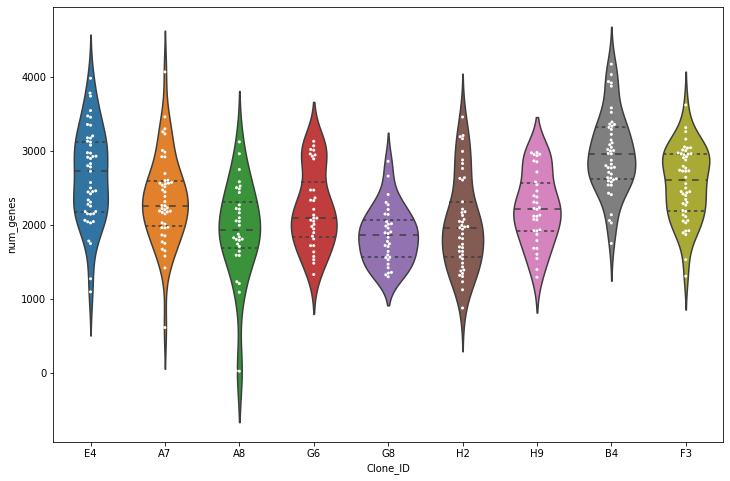

In [10]:
nG = nGene(EM_raw, meta_df)

Now we pick out the "good cells", whose expressed-gene-number is within two standard deviations of the mean (within each clone).

In [11]:
nG_std = nG.groupby('Clone_ID').apply(np.std)
nG_means = nG.groupby('Clone_ID').apply(np.mean)
nG_lowcut = (nG_means - 2*nG_std).num_genes
nG_highcut = (nG_means + 2*nG_std).num_genes
cells_good = [c for c in cells if 
              (nG.num_genes[c] >= nG_lowcut[nG.Clone_ID[c]]) and 
              (nG.num_genes[c] <= nG_highcut[nG.Clone_ID[c]]) 
             ]
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

346 cells remaining after 15 poor libraries removed.


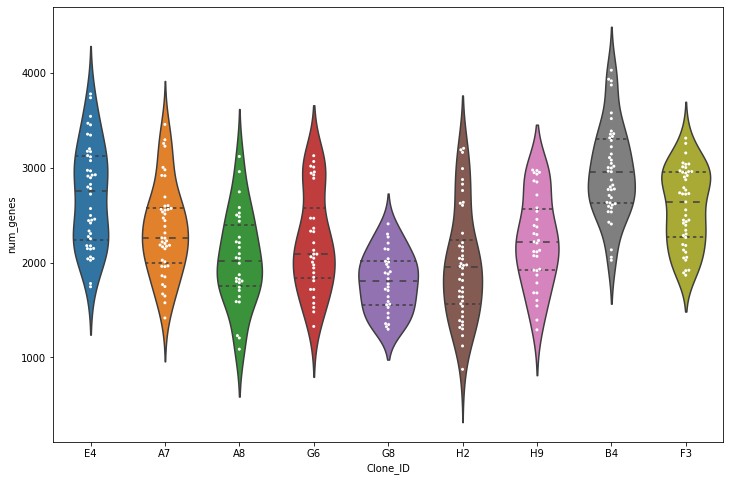

In [12]:
nG = nGene(EM_raw.loc[cells_good], meta_df.loc[cells_good]) # Post-trimming violin-plot.

#  3.  MRN Normalization.

Here we implement MRN Normalization on the gene expression data, closely following the convenient outline in Section 3.2 of [Maza](https://www.frontiersin.org/articles/10.3389/fgene.2016.00164/full).  We begin by putting our filtered data into a dataframe.  The dataframe `X` (stands for "expression matrix") contains the gene expressions for the cells, filtered as above.

In [13]:
X = EM_raw[genes_relevant].loc[cells_good]

In [14]:
X.head() # Scroll to the right to see the clonotype.

,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSCAN32,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
P1902_1289,117.0,13.868527,0.0,5.287210,2.000000,12.734072,0.028591,0.0,0.116403,0.001068,...,0.0,1.375365,0.533330,0.0,0.0,1.729030,0.0,3.000001,0.0,0.0
P1902_1290,0.0,0.029047,0.0,1.299025,0.000000,2.606228,0.005858,0.0,0.000000,0.001885,...,0.0,0.044812,0.056318,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
P1902_1291,0.0,6.034052,0.0,8.860240,202.999549,79.964810,4.312488,0.0,0.000000,0.541295,...,0.0,3.498300,12.646880,0.0,0.0,0.002202,0.0,38.000050,0.0,0.0
P1902_1293,0.0,8.431259,0.0,161.498600,0.000000,114.433240,0.219493,0.0,0.000000,0.034687,...,0.0,0.937325,317.941869,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
P1902_1294,0.0,0.157061,0.0,25.756050,0.000000,0.459234,330.002938,0.0,0.016619,4.024350,...,0.0,0.541008,7.773565,0.0,0.0,0.000301,0.0,0.000000,0.0,0.0


## Step I:  Prenormalization by library size.

In Maza's article, $X_{gkr}$ stands for the raw count (number of reads) of gene $g$, for a cell number $r$ among clone $k$.  This information is contained in our expression matrix `EM`.  The first step is to normalize by library size, dividing $X_{gkr}$ by the total number of reads $N_{kr}$ of cell with numbers $k$, $r$.  

We find the total number of reads for each cell by simply summing the numbers in each row of the data frame `X`.  We don't need to worry about the separate indices $k$ and $r$ yet.  We examine the resulting "library size" below.

In [15]:
library_size = X.sum(axis=1) # Drop the clone column.  Sum along rows.
print(library_size.head())
library_size.describe()

P1902_1289    9.491239e+05
P1902_1290    1.006230e+06
P1902_1291    1.712718e+06
P1902_1293    1.204950e+06
P1902_1294    1.000783e+06
dtype: float64


count    3.460000e+02
mean     1.576863e+06
std      5.675479e+05
min      3.731761e+05
25%      1.154661e+06
50%      1.504632e+06
75%      1.922721e+06
max      3.434468e+06
dtype: float64

The library size is about 1.6 million +/- 584,000.  Now we normalize the expression matrix by dividing every cell's raw counts by the cell's library size.  Note that `X` is a data frame whose rows are indexed by the cells.  `library_size` is a series (basically an array) whose rows are indexed by cells.  Numpy/pandas will divide one array by another, term by term, if they have the same size.  So it can divide *each column* of `X` by `library size`, in a quickly-broadcasted division.  To perform this on every column, we use the `apply` method with a "lambda" function... it's the quickest method I know.

In [16]:
Y = X.apply(lambda column : column / library_size)
Y.head()

,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSCAN32,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
P1902_1289,0.000123,1.461192e-05,0.0,0.000006,0.000002,1.341666e-05,3.012325e-08,0.0,1.226426e-07,1.125396e-09,...,0.0,1.449089e-06,5.619182e-07,0.0,0.0,1.821712e-06,0.0,0.000003,0.0,0.0
P1902_1290,0.000000,2.886682e-08,0.0,0.000001,0.000000,2.590092e-06,5.821623e-09,0.0,0.000000e+00,1.873797e-09,...,0.0,4.453407e-08,5.596913e-08,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0
P1902_1291,0.000000,3.523085e-06,0.0,0.000005,0.000119,4.668884e-05,2.517921e-06,0.0,0.000000e+00,3.160444e-07,...,0.0,2.042543e-06,7.384099e-06,0.0,0.0,1.285670e-09,0.0,0.000022,0.0,0.0
P1902_1293,0.000000,6.997184e-06,0.0,0.000134,0.000000,9.496927e-05,1.821594e-07,0.0,0.000000e+00,2.878733e-08,...,0.0,7.778954e-07,2.638631e-04,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0
P1902_1294,0.000000,1.569382e-07,0.0,0.000026,0.000000,4.588748e-07,3.297448e-04,0.0,1.660620e-08,4.021202e-06,...,0.0,5.405849e-07,7.767485e-06,0.0,0.0,3.005597e-10,0.0,0.000000,0.0,0.0


Now `Y` is the dataframe with counts normalized by library size, and we pass to the next step.

## Step II:  Creation of reference sample.

A difference between TMM (used in edgeR), RLE (used in DeSeq2), and MRN, is how they create a reference sample.  In MRN, a reference sample is created by averaging the previous dataframe `Y` over cells within a single condition (clone).  We carry this out here.

Note the method-chaining in defining `Y_clonal` below.  The `assign` method tacks on a new column to `Y` for the clone_IDs.  The `groupby` method then groups cells by clonotypes.  The `apply` method then takes the means within each clonotype.  The end result is to replace the (prenormalized) gene expression for *each cell* by the averages for each clonotype.  

In [17]:
Y_clonal = Y.assign(Clone=meta_df['Clone_ID']).groupby('Clone').apply(np.mean) # Takes a few seconds.
display(Y_clonal)

,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSCAN32,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
Clone,,,,,,,,,,,,,,,,,,,,,
A7,0.000033,1.849234e-06,0.000014,0.000090,0.000061,0.000079,2.172950e-05,0.000083,0.000026,8.264517e-07,...,6.515959e-06,3.279755e-06,0.000011,0.000022,0.000042,0.000033,1.131244e-04,0.000049,2.446727e-05,0.000040
A8,0.000009,1.771044e-06,0.000021,0.000074,0.000183,0.000067,7.816341e-07,0.000086,0.000088,1.228354e-06,...,3.607288e-05,4.718368e-07,0.000023,0.000017,0.000025,0.000020,0.000000e+00,0.000090,1.406587e-05,0.000006
B4,0.000031,1.991826e-06,0.000036,0.000057,0.000095,0.000069,1.128297e-05,0.000058,0.000057,1.992993e-06,...,3.960894e-05,3.575998e-06,0.000010,0.000018,0.000010,0.000060,1.936374e-04,0.000072,1.149041e-05,0.000012
E4,0.000006,1.710909e-06,0.000009,0.000080,0.000073,0.000074,5.138985e-06,0.000046,0.000035,1.831048e-06,...,1.672850e-05,3.449031e-06,0.000006,0.000017,0.000015,0.000029,7.424980e-05,0.000024,9.097176e-06,0.000014
F3,0.000003,1.183032e-06,0.000035,0.000046,0.000069,0.000066,1.947141e-06,0.000116,0.000026,8.954851e-07,...,4.891164e-05,1.520676e-06,0.000012,0.000024,0.000014,0.000033,5.085944e-06,0.000055,3.333018e-05,0.000022
G6,0.000019,3.258622e-06,0.000041,0.000055,0.000084,0.000028,1.211898e-06,0.000081,0.000012,1.199664e-06,...,3.595306e-05,2.169012e-06,0.000011,0.000018,0.000050,0.000050,0.000000e+00,0.000052,3.745430e-05,0.000035
G8,0.000002,2.509980e-06,0.000000,0.000075,0.000056,0.000137,3.684549e-07,0.000123,0.000064,1.176179e-06,...,2.887923e-08,4.835308e-06,0.000016,0.000015,0.000032,0.000024,0.000000e+00,0.000006,0.000000e+00,0.000014
H2,0.000024,7.118831e-07,0.000017,0.000122,0.000118,0.000045,9.610956e-06,0.000042,0.000022,1.521682e-06,...,5.632465e-06,2.215524e-06,0.000037,0.000010,0.000022,0.000035,1.956655e-04,0.000078,2.095809e-07,0.000014
H9,0.000009,1.273696e-06,0.000010,0.000078,0.000075,0.000066,7.869374e-06,0.000120,0.000020,1.228811e-06,...,2.196204e-05,4.400050e-06,0.000007,0.000006,0.000036,0.000020,1.178874e-08,0.000005,8.385331e-07,0.000024


Let's take our reference sample to be the A7 clonal average.

In [18]:
Y_ref = Y_clonal.loc['A7'] # Our reference sample.  Basically an average of all cells of clonotype A7.
Y_ref.describe()

count    8627.000000
mean        0.000116
std         0.000822
min         0.000000
25%         0.000012
50%         0.000033
75%         0.000082
max         0.045092
Name: A7, dtype: float64

## Step III:  Computation of size relative to reference sample.

Now we compute relative scaling factors for each clone, based on the median fold-changes between gene expression within that clone and the reference clone (A7, we have chosen above).  Due to dropouts (values of 0 in gene expression), we discard genes with zeros when computing fold changes.  This avoids division-by-zero problems, and it matches the implementation of [Maza et al.](https://www.tandfonline.com/doi/full/10.4161/cib.25849).  (See the R code in the supplementary information).  

In [19]:
tau = pd.Series(index = clones)
for clone in clones: # Why not a little loop.
    numerator = Y_clonal.loc[clone]
    denominator = Y_ref
    ok_genes = [gene for gene in genes_relevant if (numerator[gene] != 0) and (denominator[gene] != 0)]
    ratios = numerator[ok_genes] / denominator[ok_genes] # The ratios.
    tau[clone] = np.median(ratios)
print(tau)

A7    1.000000
A8    1.010532
B4    1.115866
E4    0.972520
F3    0.986251
G6    1.043095
G8    0.993050
H2    0.949730
H9    0.838977
dtype: float64


## Step IV:  Adjustment of relative scaling factors.

This step does not occur in MRN normalization.  Yay!

## Step V:  Effective library size.

In [20]:
#intermediate series to match the clone IDs with the samples
meta_lib_size = pd.Series(meta_df['Clone_ID'], index=library_size.index)
meta_lib_size.head()

P1902_1289    E4
P1902_1290    E4
P1902_1291    E4
P1902_1293    A7
P1902_1294    A7
Name: Clone_ID, dtype: object

In [21]:
#intermediate series to map tau scaling values to the samples
scalar_lib_size = meta_lib_size.map(tau)
scalar_lib_size.head()

P1902_1289    0.97252
P1902_1290    0.97252
P1902_1291    0.97252
P1902_1293    1.00000
P1902_1294    1.00000
Name: Clone_ID, dtype: float64

In [22]:
#final series, for this step at least as the library_size values are scaled by tau values
effective_lib_size = scalar_lib_size * library_size
effective_lib_size.head()

P1902_1289    9.230417e+05
P1902_1290    9.785782e+05
P1902_1291    1.665652e+06
P1902_1293    1.204950e+06
P1902_1294    1.000783e+06
dtype: float64

## Step VI:  Computation of relative normalization/size factors.

In [23]:
#factor, f
#print(effective_lib_size.head())
factor_log = effective_lib_size.apply(np.log)
#print(factor_log.head())
factor_cumsum = factor_log.cumsum()
#print(factor_cumsum.head())
factor_mean_by_position = factor_cumsum / list(range(1, len(library_size)+1))
#print(factor_mean_by_position.head())
relative_normalization_factor = factor_mean_by_position.apply(np.exp)
print(relative_normalization_factor.head())

P1902_1289    9.230417e+05
P1902_1290    9.504043e+05
P1902_1291    1.145866e+06
P1902_1293    1.160359e+06
P1902_1294    1.126528e+06
dtype: float64


## Step VII:  Normalization of counts.

In [24]:
X.head()

,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSCAN32,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
P1902_1289,117.0,13.868527,0.0,5.287210,2.000000,12.734072,0.028591,0.0,0.116403,0.001068,...,0.0,1.375365,0.533330,0.0,0.0,1.729030,0.0,3.000001,0.0,0.0
P1902_1290,0.0,0.029047,0.0,1.299025,0.000000,2.606228,0.005858,0.0,0.000000,0.001885,...,0.0,0.044812,0.056318,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
P1902_1291,0.0,6.034052,0.0,8.860240,202.999549,79.964810,4.312488,0.0,0.000000,0.541295,...,0.0,3.498300,12.646880,0.0,0.0,0.002202,0.0,38.000050,0.0,0.0
P1902_1293,0.0,8.431259,0.0,161.498600,0.000000,114.433240,0.219493,0.0,0.000000,0.034687,...,0.0,0.937325,317.941869,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
P1902_1294,0.0,0.157061,0.0,25.756050,0.000000,0.459234,330.002938,0.0,0.016619,4.024350,...,0.0,0.541008,7.773565,0.0,0.0,0.000301,0.0,0.000000,0.0,0.0


In [25]:
# here we normalize our raw counts by the relative normalization factor we just
# calculated in step vi
mrn_counts = X.div(relative_normalization_factor, axis=0)
mrn_counts.head()

,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSCAN32,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3
P1902_1289,0.000127,1.502481e-05,0.0,0.000006,0.000002,1.379577e-05,3.097444e-08,0.0,1.261081e-07,1.157196e-09,...,0.0,1.490036e-06,5.777962e-07,0.0,0.0,1.873187e-06,0.0,0.000003,0.0,0.0
P1902_1290,0.000000,3.056241e-08,0.0,0.000001,0.000000,2.742231e-06,6.163577e-09,0.0,0.000000e+00,1.983861e-09,...,0.0,4.714993e-08,5.925667e-08,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0
P1902_1291,0.000000,5.265933e-06,0.0,0.000008,0.000177,6.978550e-05,3.763520e-06,0.0,0.000000e+00,4.723896e-07,...,0.0,3.052976e-06,1.103697e-05,0.0,0.0,1.921683e-09,0.0,0.000033,0.0,0.0
P1902_1293,0.000000,7.266075e-06,0.0,0.000139,0.000000,9.861879e-05,1.891595e-07,0.0,0.000000e+00,2.989358e-08,...,0.0,8.077887e-07,2.740029e-04,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0
P1902_1294,0.000000,1.394204e-07,0.0,0.000023,0.000000,4.076543e-07,2.929381e-04,0.0,1.475258e-08,3.572348e-06,...,0.0,4.802437e-07,6.900463e-06,0.0,0.0,2.670107e-10,0.0,0.000000,0.0,0.0


##### Just a lil thing i found from diffTF
I thought this is relevant # Perform a cyclic loess normalization
    We use a slighlty more complicated setup to derive size factors for library normalization
   Instead of just determining the size factors in DeSeq2 via cirtual samples, we use
    a normalization from the csaw package (see https://www.rdocumentation.org/packages/csaw/versions/1.6.1/topics/normOffsets)
    and apply a non-linear normalization.
    For each sample, a lowess curve is fitted to the log-counts against the log-average count.
    The fitted value for each bin pair is used as the generalized linear model offset for that sample.
   The use of the average count provides more stability than the average log-count when low counts are present for differentially bound regions.

# 4.  Quick shot at machine learning

After preprocessing the data, one might want to quickly check how well gene expression can predict clonotype.  The following steps will test out a linear support vector classifier. 

In [26]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


In [27]:
#X = X_normalized
X_cells = mrn_counts.index
y = meta_df.loc[X_cells].Clone_ID

In [28]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [29]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = range(50,251,25),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('selectkbest',
                                        SelectKBest(k=100,
                                                    score_func=<function f_classif at 0x1a1c0f3c80>)),
                                       ('linearsvc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=2000,
                                                  multi_class='ovr',
  

In [30]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

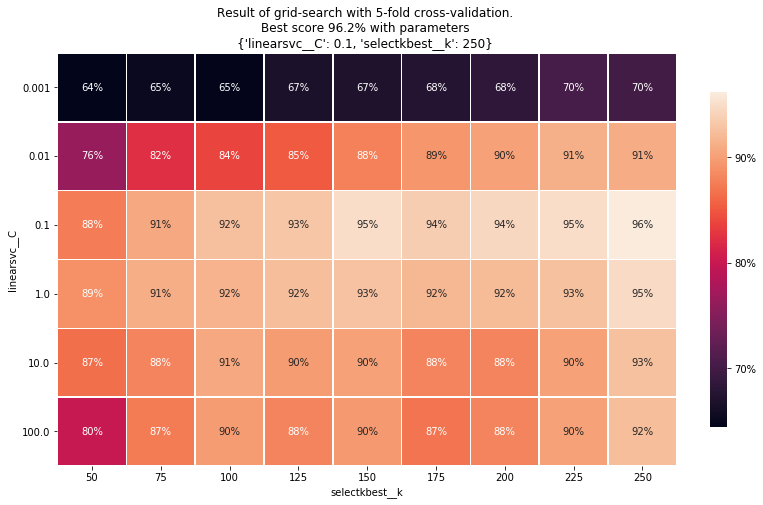

In [31]:
CV_map(grid_search)

In [32]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(len(classes)+1,len(classes)))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

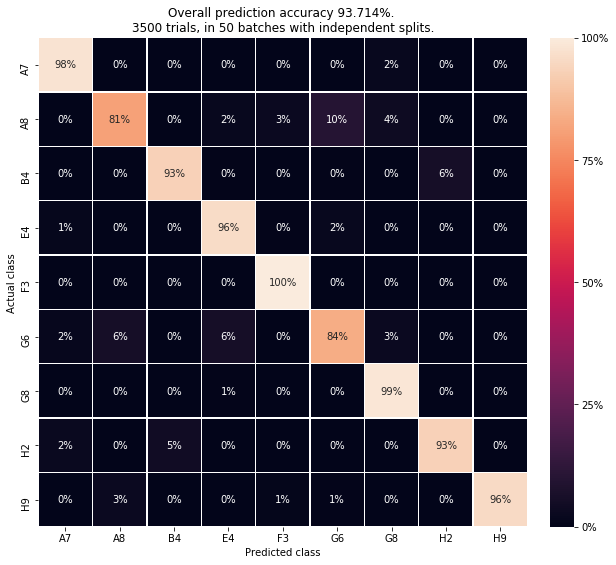

In [33]:
opt_k = grid_search.best_params_['selectkbest__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['linearsvc__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=50, classlist = clones)